In [1]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
import os
import sys
import pickle
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [2]:
from pathlib import Path
import os
import sys
from validutils_zwad.read_data import read_data

In [3]:
# First of all: load data

from zwad.utils import load_data

def feature_file(oid_file):
    parent = oid_file.parent
    if oid_file.name.startswith('oid_'):
        name = oid_file.name.replace('oid_', 'feature_')
    else:
        name = oid_file.name.replace('sid_', 'feature_')
    
    return parent.joinpath(name)
    

datadir = Path('../features_data', 'dr4_new')
sid_extragal_gr = datadir.joinpath('sid_extragal_short_gr_100_rchi2min3.dat')
feature_extragal_gr = feature_file(sid_extragal_gr)

fakesdir = Path('../sim_fake', 'output')
sid_fakes = list(fakesdir.glob('oid_*.dat'))
feature_fakes = [feature_file(s) for s in sid_fakes]


fakesids, fakefeatures = load_data(sid_fakes, feature_fakes)
dr4sids, dr4features = load_data([sid_extragal_gr], [feature_extragal_gr])
sids, features = load_data([sid_extragal_gr] + sid_fakes, [feature_extragal_gr] + feature_fakes)

In [4]:
dr4_index = [sids > 1e10]
dr4_sids = sids[dr4_index]
dr4_features = features[dr4_index]

fakes_index = [sids < 1e10]
fakes_sids = sids[fakes_index]
fakes_features = features[fakes_index]

feature_names = Path('../features_data', 
                     'dr4_new', 
                     'feature_extragal_short_gr_100_rchi2min3.name').open('r').read().split('\n')[:-1] #drop extra white space at end

dr4_df = pd.DataFrame(dr4_features, index=dr4_sids, columns=feature_names)
fakes_df = pd.DataFrame(fakes_features, index=fakes_sids, columns=feature_names)


<ipython-input-4-7ab99dbe4acd>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dr4_sids = sids[dr4_index]
<ipython-input-4-7ab99dbe4acd>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dr4_features = features[dr4_index]
<ipython-input-4-7ab99dbe4acd>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  fakes_sids = s

In [5]:
feature_names

['amplitude_magn_g',
 'anderson_darling_normal_magn_g',
 'beyond_1_std_magn_g',
 'beyond_2_std_magn_g',
 'cusum_magn_g',
 'eta_e_magn_g',
 'inter_percentile_range_2_magn_g',
 'inter_percentile_range_10_magn_g',
 'inter_percentile_range_25_magn_g',
 'kurtosis_magn_g',
 'linear_fit_slope_magn_g',
 'linear_fit_slope_sigma_magn_g',
 'linear_fit_reduced_chi2_magn_g',
 'linear_trend_magn_g',
 'linear_trend_sigma_magn_g',
 'magnitude_percentage_ratio_40_5_magn_g',
 'magnitude_percentage_ratio_20_5_magn_g',
 'maximum_slope_magn_g',
 'mean_magn_g',
 'median_absolute_deviation_magn_g',
 'median_buffer_range_percentage_10_magn_g',
 'median_buffer_range_percentage_20_magn_g',
 'percent_amplitude_magn_g',
 'percent_difference_magnitude_percentile_5_magn_g',
 'percent_difference_magnitude_percentile_10_magn_g',
 'period_0_magn_g',
 'period_s_to_n_0_magn_g',
 'period_1_magn_g',
 'period_s_to_n_1_magn_g',
 'period_2_magn_g',
 'period_s_to_n_2_magn_g',
 'period_3_magn_g',
 'period_s_to_n_3_magn_g',
 'p

In [6]:
drop_features_list = ['eta_e_magn_g', 
                      'linear_fit_reduced_chi2_magn_g',
                      'maximum_slope_magn_g', 
                      'period_0_magn_g', 
                      'period_1_magn_g',
                      'period_2_magn_g',
                      'period_3_magn_g',
                      'period_4_magn_g',
                      'periodogram_amplitude_magn_g',
                      'chi2_magn_g',
                      'eta_e_flux_g',
                      'chi2_flux_g',
                      'eta_e_magn_r',
                      'linear_fit_reduced_chi2_magn_r',
                      'maximum_slope_magn_r',
                      'period_0_magn_r',
                      'period_1_magn_r',
                      'period_2_magn_r',
                      'period_3_magn_r',
                      'period_4_magn_r',
                      'periodogram_amplitude_magn_r',
                      'chi2_magn_r',
                      'eta_e_flux_r',
                      'chi2_flux_r']

dr4_df = dr4_df.drop(columns=drop_features_list)
fakes_df = fakes_df.drop(columns=drop_features_list)

dr4_df.index.name = 'sid'
fakes_df.index.name = 'sid'

# Restrict fakes_df to the 7 we used in the mining
#'6439074373', #TDE 
#'9020928999', #SN Ia
#'6011793767', #SLSN
#'4229763628', #SN II
#'6417979422', #TDE-- 
#'6031286883', #SLSN
#'604029941', #SLSN--

fakes_mining_sids = ['6439074373', '9020928999', '6011793767', '4229763628', '6417979422', '6031286883', '604029941']
fakes_mining_sids_int = list(map(int, fakes_mining_sids))

fakes_df = fakes_df[fakes_df.index.isin(fakes_mining_sids)].drop_duplicates()
fakes_df = fakes_df.reindex(fakes_mining_sids_int)

# Save fakes Df and DR4 DF 
#fakes_df.to_csv("./dataframes/orig_fakes_df.csv.gzip", compression='gzip')
#dr4_df.to_csv("./dataframes/orig_dr4_df.csv.gzip", compression='gzip')

# Load

In [7]:
# Load fakes Df and DR4 DF from find_closest_fake_detction
#fakes_df = pd.read_csv("./dataframes/orig_fakes_df.csv.gzip", compression='gzip', index_col=0)
#dr4_df = pd.read_csv("./dataframes/orig_dr4_df.csv.gzip", compression='gzip', index_col=0)

fakes_mining_sids = ['6439074373', '9020928999', '6011793767', '4229763628', '6417979422', '6031286883', '604029941']
fakes_mining_sids_int = list(map(int, fakes_mining_sids))

fakes_df = fakes_df.reindex(fakes_mining_sids_int)

# Load fakes Df and DR4 DF from find_closest_fake_detction
#fakes_df = pd.read_csv("./dataframes/fakes_df.csv.gzip", compression='gzip', index_col=0)
#dr4_df = pd.read_csv("./dataframes/dr4_df.csv.gzip", compression='gzip', index_col=0)

In [8]:
dr4_df

,amplitude_magn_g,anderson_darling_normal_magn_g,beyond_1_std_magn_g,beyond_2_std_magn_g,cusum_magn_g,inter_percentile_range_2_magn_g,inter_percentile_range_10_magn_g,inter_percentile_range_25_magn_g,kurtosis_magn_g,linear_fit_slope_magn_g,...,standard_deviation_magn_r,stetson_K_magn_r,weighted_mean_magn_r,anderson_darling_normal_flux_r,cusum_flux_r,excess_variance_flux_r,kurtosis_flux_r,mean_variance_flux_r,skew_flux_r,stetson_K_flux_r
sid,,,,,,,,,,,,,,,,,,,,,
245101100000933,0.177000,3.696596,0.370000,0.030000,0.158870,0.341499,0.286501,0.158501,-0.787381,-0.000212,...,0.097860,0.851286,15.842624,2.711263,0.099072,0.007498,-0.944294,0.087656,-0.507747,0.844530
245101100009703,0.293500,2.724011,0.290000,0.060000,0.184453,0.523001,0.333000,0.104000,0.201318,-0.001444,...,0.130134,0.869721,15.653200,4.130320,0.156431,0.013800,-1.050300,0.118238,-0.059173,0.909857
245101100010242,0.328500,5.493390,0.190000,0.050000,0.229448,0.559999,0.220499,0.094999,5.286414,-0.001808,...,0.068449,0.672620,16.533829,4.853297,0.187999,0.004273,8.948397,0.067449,2.465220,0.683464
245104200000799,0.329500,2.502895,0.467290,0.000000,0.089224,0.593760,0.490400,0.350000,-1.362500,0.000242,...,0.123850,0.858237,17.937359,1.524028,0.131790,0.011540,-0.980239,0.112776,-0.026306,0.870056
245104200000939,2.293000,12.605539,0.066038,0.056604,0.177457,4.114202,1.156300,0.426999,9.274009,-0.003301,...,0.394907,0.789900,15.854793,1.492581,0.322914,0.081920,0.337605,0.286570,0.109400,0.675794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597113100010642,0.483999,1.274301,0.293578,0.055046,0.187018,0.595680,0.369799,0.157999,1.613005,-0.001550,...,0.107312,0.680863,18.940697,5.417244,0.233112,0.008082,5.852146,0.105139,1.738649,0.670839
1597113100019088,0.323501,1.453954,0.271186,0.076271,0.202899,0.490780,0.252100,0.097000,1.162233,-0.001054,...,0.079516,0.702109,17.359133,3.377403,0.154508,0.005559,5.974216,0.076836,1.682657,0.710270
1597113100031221,0.074500,0.266636,0.307692,0.025641,0.153808,0.093640,0.060800,0.032499,1.197538,-0.000101,...,0.031295,0.753234,13.399863,0.861085,0.155385,0.000762,1.899416,0.029034,0.619902,0.756356


In [9]:
fakes_df

,amplitude_magn_g,anderson_darling_normal_magn_g,beyond_1_std_magn_g,beyond_2_std_magn_g,cusum_magn_g,inter_percentile_range_2_magn_g,inter_percentile_range_10_magn_g,inter_percentile_range_25_magn_g,kurtosis_magn_g,linear_fit_slope_magn_g,...,standard_deviation_magn_r,stetson_K_magn_r,weighted_mean_magn_r,anderson_darling_normal_flux_r,cusum_flux_r,excess_variance_flux_r,kurtosis_flux_r,mean_variance_flux_r,skew_flux_r,stetson_K_flux_r
sid,,,,,,,,,,,,,,,,,,,,,
6439074373,2.313272,6.242598,0.544218,0.0,0.458069,4.586686,4.375262,3.713085,-1.596927,0.005899,...,1.631735,0.946339,17.689695,15.523734,0.437505,1.315818,-0.902408,1.148051,0.874291,0.773280
9020928999,2.027956,6.452106,0.429448,0.0,0.444023,3.941975,3.314264,2.360711,-1.283149,0.020341,...,1.056116,0.922816,17.861500,11.056737,0.425569,0.794369,-0.423881,0.892017,0.947871,0.790745
6011793767,2.428476,16.336357,0.472656,0.0,0.448958,4.651444,4.122466,3.430849,-1.429027,0.007894,...,1.330221,0.909978,17.374739,24.971611,0.458264,0.785898,-1.554181,0.888269,0.386377,0.835887
4229763628,2.439133,3.030501,0.386555,0.0,0.448217,4.545591,3.327130,2.430037,-1.277114,0.020108,...,1.403626,0.934688,16.848856,11.799259,0.457372,0.944930,-1.367946,0.972413,0.601326,0.789646
6417979422,1.925718,1.752841,0.408163,0.0,0.425961,3.716248,3.240535,1.999153,-1.147905,0.019292,...,1.124392,0.929654,18.555391,11.669273,0.424440,0.915662,-0.432657,0.958406,0.998215,0.773014
6031286883,2.260002,6.587531,0.496504,0.0,0.449040,4.501166,4.036433,3.082117,-1.428517,0.015139,...,1.292708,0.919051,17.772713,11.349049,0.456618,0.721447,-1.440829,0.850721,0.452070,0.818922
604029941,2.164002,2.823114,0.424528,0.0,0.429195,4.264567,3.573987,2.523350,-1.250747,0.013158,...,1.222392,0.950357,17.867418,10.617710,0.436003,1.027209,-0.894394,1.014422,0.899074,0.741584


In [10]:
%%time

#from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree

# Hardest to find fakes
X = np.vstack(fakes_df.values)
kdtree = cKDTree(dr4_df)
#pickle.dump(kdtree,open('./orig_kdtree.p','wb'))

dist, ind = kdtree.query(X, k=15)

CPU times: user 3.45 s, sys: 314 ms, total: 3.77 s
Wall time: 3.77 s


In [11]:
k_neighbor = 1

print(dist[:, k_neighbor])    
print(ind[:, k_neighbor])     

[11.58408333 11.4697431  12.76310819  9.73971994 11.32007183 10.64706142
  9.81478907]
[204160 730595 307386 504755 928753 204160  98743]


In [12]:
kdtree_results_df = pd.DataFrame()
kdtree_results_df['sid'] = fakes_df.index
kdtree_results_df = kdtree_results_df.set_index('sid')

kdtree_dist_df = kdtree_results_df.copy()

for knn in range(0,15):    
    dr4_match_oid, dr4_match_dist = [],[]
    for ix, dis in zip(ind[:, knn], dist[:, knn]):
        dr4_match_oid.append(dr4_df.iloc[ix].name)
        dr4_match_dist.append(dis)
    kdtree_results_df[f'knn={knn+1}_match_OID'] = dr4_match_oid
    kdtree_dist_df[f'knn={knn+1}_dist'] = dr4_match_dist

In [13]:
kdtree_results_df = kdtree_results_df.reindex(fakes_mining_sids_int)
#kdtree_results_df.to_csv("./dataframes/orig_kdtree_results_df.csv.gzip", compression='gzip')
kdtree_results_df

,knn=1_match_OID,knn=2_match_OID,knn=3_match_OID,knn=4_match_OID,knn=5_match_OID,knn=6_match_OID,knn=7_match_OID,knn=8_match_OID,knn=9_match_OID,knn=10_match_OID,knn=11_match_OID,knn=12_match_OID,knn=13_match_OID,knn=14_match_OID,knn=15_match_OID
sid,,,,,,,,,,,,,,,
6439074373,407113200000457,636102100000584,789115200006620,679108100003227,681115400012617,643105300009229,636116100005131,790103100000915,594109100004829,839103100009823,483105400003296,676101100005215,719102100006086,757115100002190,793107200002055
9020928999,723103100016148,792111100012457,844106400002117,843110200002130,679108100003227,789115200006620,719102100006086,681115400012617,721110100002360,755103100026105,684115200018744,407113200000457,721106300009409,792101400013907,766111300018322
6011793767,677116400000863,677105300002652,677106200003154,823109200001894,473115200000118,822104100001763,669113100003919,677110300002781,822110200011495,676101300005635,587101300003767,819111400000931,677102400003100,595116200000958,677112100002841
4229763628,792112400009928,723113400015131,681115400012617,643110100008514,757115100002190,790103100000915,721105100002309,759110300004319,715109100000034,847114100003486,840109400004740,790111400004261,758111400001153,634108100006647,792105300007593
6417979422,698103400000840,849102200015533,754109300001159,643115100008829,691102100003503,643104100004109,717104100000099,643115300006159,718105300007353,752101400010658,643102200008503,525109400003682,790111400004261,793111200009141,525116300002048
6031286883,817105300001401,636102100000584,698103400000840,407113200000457,828103400007547,679108100003227,588113200030350,681115400012617,692108100000145,595108400006567,692114300003891,849102200015533,695105400005983,849109300006928,524115200000956
604029941,452109400000422,583101400001339,695111400014397,857106200000362,817105300001401,648115400000608,596113100008238,496112100004755,649110400002437,346105100008449,497116200001007,608105100013926,735111200007977,860110200001184,864111200008339


In [14]:
kdtree_dist_df = kdtree_dist_df.reindex(fakes_mining_sids_int)
#kdtree_dist_df.to_csv("./dataframes/orig_kdtree_dist_df.csv.gzip", compression='gzip')
kdtree_dist_df

,knn=1_dist,knn=2_dist,knn=3_dist,knn=4_dist,knn=5_dist,knn=6_dist,knn=7_dist,knn=8_dist,knn=9_dist,knn=10_dist,knn=11_dist,knn=12_dist,knn=13_dist,knn=14_dist,knn=15_dist
sid,,,,,,,,,,,,,,,
6439074373,11.336420,11.584083,12.025293,12.182730,12.290313,12.656884,12.848355,13.123504,13.242283,13.269816,13.330249,13.590585,13.650197,13.664398,13.764815
9020928999,10.713955,11.469743,11.539383,11.951278,12.307632,12.505227,12.716438,13.152154,13.211295,13.213997,13.234361,13.375029,13.391075,13.627144,13.770812
6011793767,12.162402,12.763108,13.255325,13.342560,13.560544,13.777844,13.943795,14.002607,14.153023,14.183731,14.225434,14.301980,14.367716,14.451298,14.627646
4229763628,9.528587,9.739720,10.771593,10.867767,11.056505,11.087045,11.237477,11.328809,11.664940,11.760918,11.786352,11.844446,11.934909,12.037676,12.038289
6417979422,11.001441,11.320072,11.883241,12.009407,12.035704,12.070034,12.157690,12.184649,12.293069,12.585433,12.635781,12.719778,12.809086,12.877865,12.918699
6031286883,9.002645,10.647061,10.868295,10.964766,11.073632,11.174942,11.260068,11.329955,11.524593,11.525108,11.575215,11.774228,11.784514,11.868382,11.868803
604029941,8.864156,9.814789,10.270778,10.564302,10.633698,10.653659,10.823482,10.913876,10.963079,11.034163,11.071214,11.212506,11.231398,11.253751,11.269862


In [15]:
len(np.unique(np.hstack(kdtree_results_df.values)))

89

In [16]:
len(np.hstack(kdtree_results_df.values))

105

In [17]:
from IPython.display import display_markdown

for knn in range(0,15):
    print(f"KNN {knn+1} \n")
    _ = [display_markdown(f'https://ztf.snad.space/view/{oid}', raw=True) for oid in \
         kdtree_results_df[f'knn={knn+1}_match_OID']]

KNN 1 



https://ztf.snad.space/view/407113200000457

https://ztf.snad.space/view/723103100016148

https://ztf.snad.space/view/677116400000863

https://ztf.snad.space/view/792112400009928

https://ztf.snad.space/view/698103400000840

https://ztf.snad.space/view/817105300001401

https://ztf.snad.space/view/452109400000422

KNN 2 



https://ztf.snad.space/view/636102100000584

https://ztf.snad.space/view/792111100012457

https://ztf.snad.space/view/677105300002652

https://ztf.snad.space/view/723113400015131

https://ztf.snad.space/view/849102200015533

https://ztf.snad.space/view/636102100000584

https://ztf.snad.space/view/583101400001339

KNN 3 



https://ztf.snad.space/view/789115200006620

https://ztf.snad.space/view/844106400002117

https://ztf.snad.space/view/677106200003154

https://ztf.snad.space/view/681115400012617

https://ztf.snad.space/view/754109300001159

https://ztf.snad.space/view/698103400000840

https://ztf.snad.space/view/695111400014397

KNN 4 



https://ztf.snad.space/view/679108100003227

https://ztf.snad.space/view/843110200002130

https://ztf.snad.space/view/823109200001894

https://ztf.snad.space/view/643110100008514

https://ztf.snad.space/view/643115100008829

https://ztf.snad.space/view/407113200000457

https://ztf.snad.space/view/857106200000362

KNN 5 



https://ztf.snad.space/view/681115400012617

https://ztf.snad.space/view/679108100003227

https://ztf.snad.space/view/473115200000118

https://ztf.snad.space/view/757115100002190

https://ztf.snad.space/view/691102100003503

https://ztf.snad.space/view/828103400007547

https://ztf.snad.space/view/817105300001401

KNN 6 



https://ztf.snad.space/view/643105300009229

https://ztf.snad.space/view/789115200006620

https://ztf.snad.space/view/822104100001763

https://ztf.snad.space/view/790103100000915

https://ztf.snad.space/view/643104100004109

https://ztf.snad.space/view/679108100003227

https://ztf.snad.space/view/648115400000608

KNN 7 



https://ztf.snad.space/view/636116100005131

https://ztf.snad.space/view/719102100006086

https://ztf.snad.space/view/669113100003919

https://ztf.snad.space/view/721105100002309

https://ztf.snad.space/view/717104100000099

https://ztf.snad.space/view/588113200030350

https://ztf.snad.space/view/596113100008238

KNN 8 



https://ztf.snad.space/view/790103100000915

https://ztf.snad.space/view/681115400012617

https://ztf.snad.space/view/677110300002781

https://ztf.snad.space/view/759110300004319

https://ztf.snad.space/view/643115300006159

https://ztf.snad.space/view/681115400012617

https://ztf.snad.space/view/496112100004755

KNN 9 



https://ztf.snad.space/view/594109100004829

https://ztf.snad.space/view/721110100002360

https://ztf.snad.space/view/822110200011495

https://ztf.snad.space/view/715109100000034

https://ztf.snad.space/view/718105300007353

https://ztf.snad.space/view/692108100000145

https://ztf.snad.space/view/649110400002437

KNN 10 



https://ztf.snad.space/view/839103100009823

https://ztf.snad.space/view/755103100026105

https://ztf.snad.space/view/676101300005635

https://ztf.snad.space/view/847114100003486

https://ztf.snad.space/view/752101400010658

https://ztf.snad.space/view/595108400006567

https://ztf.snad.space/view/346105100008449

KNN 11 



https://ztf.snad.space/view/483105400003296

https://ztf.snad.space/view/684115200018744

https://ztf.snad.space/view/587101300003767

https://ztf.snad.space/view/840109400004740

https://ztf.snad.space/view/643102200008503

https://ztf.snad.space/view/692114300003891

https://ztf.snad.space/view/497116200001007

KNN 12 



https://ztf.snad.space/view/676101100005215

https://ztf.snad.space/view/407113200000457

https://ztf.snad.space/view/819111400000931

https://ztf.snad.space/view/790111400004261

https://ztf.snad.space/view/525109400003682

https://ztf.snad.space/view/849102200015533

https://ztf.snad.space/view/608105100013926

KNN 13 



https://ztf.snad.space/view/719102100006086

https://ztf.snad.space/view/721106300009409

https://ztf.snad.space/view/677102400003100

https://ztf.snad.space/view/758111400001153

https://ztf.snad.space/view/790111400004261

https://ztf.snad.space/view/695105400005983

https://ztf.snad.space/view/735111200007977

KNN 14 



https://ztf.snad.space/view/757115100002190

https://ztf.snad.space/view/792101400013907

https://ztf.snad.space/view/595116200000958

https://ztf.snad.space/view/634108100006647

https://ztf.snad.space/view/793111200009141

https://ztf.snad.space/view/849109300006928

https://ztf.snad.space/view/860110200001184

KNN 15 



https://ztf.snad.space/view/793107200002055

https://ztf.snad.space/view/766111300018322

https://ztf.snad.space/view/677112100002841

https://ztf.snad.space/view/792105300007593

https://ztf.snad.space/view/525116300002048

https://ztf.snad.space/view/524115200000956

https://ztf.snad.space/view/864111200008339

In [18]:
match_results_df = pd.DataFrame()
match_results_df['sid'] = fakes_df.index
match_results_df = match_results_df.set_index('sid')

# Use generic classes: Varstar, Gal, QSO, SN, uncatalogued, artifacts 
# Simple table of NON-UNIQUE COUNTS
#   Type           (count) |         Subtype(s)     
# Varstar types (count=49): RR Lyrae (27), UG (15), Cepheid (1), Mira (3), SR (2), RS CVn (1)
# QSO types (count=18): QSO (17), BLLAC (1)
# Galaxy types (count=3): Seyfert (2), Radio (1)
# SN (count=26): Known (10 total -- 7 unique), new SNAD (16 total -- 11 unique) (see Table abc!)
# uncatalogued (count=9): 8 [4 (QSO) + 5 (SN/AGN)]
# artifacts (count=0): 0
# TOTAL (count=105)

# [6439074373, 9020928999, 6011793767, 4229763628, 6417979422, 6031286883, 604029941]

# KNOWN/REPORTED SN:
# Name                                       KNN        SIM TYPE   
# AT 2019mzp (reported SN! -- ATLAS20hzm) | KNN=2 | SID=604029941 (SLSN) | ZTF OID=583101400001339
# AT 2019gsn (reported SN! -- ATLAS19mbr) | KNN=3 | SID=4229763628 (SN II) | ZTF OID=681115400012617
# "                                   "  | KNN=5 | SID=6439074373 (TDE) | ZTF OID=681115400012617
# "                                   "  | KNN=8 | SID=9020928999 (SN Ia) | ZTF OID=681115400012617
# "                                   "  | KNN=8 | SID=604029941 (SLSN) | ZTF OID=681115400012617
# AT 2018lxn (reported SN! -- SNAD129)    | KNN=9 | SID=9020928999 (SN Ia) | ZTF OID=721110100002360
# AT 2018bhq (reported SN! -- ATLAS18oay) | KNN=12 | SID=6439074373 (TDE) | ZTF OID=676101100005215
# SN 2018aej (spec SN Ia -- PS18mh)       | KNN=13 | SID=9020928999 (SN Ia) | ZTF OID=721106300009409
# AT 2018dvs (reported SN! -- ZTF19aaqejgh) | KNN=14 | SID=9020928999 (SN Ia) | ZTF OID=792101400013907
# SN 2018aoy (spec SN Ia -- ATLAS18mzo | KNN=15 | SID=6439074373 (TDE) | ZTF OID=793107200002055

# Transient Mining SNAD Discoveries (this work):
# Name                  KNN        SIM TYPE                 
# SNAD152/AT 2018lyx | KNN=2 | SID=9020928999 (SN Ia) | ZTF OID=792111100012457
# SNAD149/AT 2018lyu | KNN=2 | SID=6417979422 (TDE) | ZTF OID=849102200015533
# "                " | KNN=12 | SID=6031286883 (SLSN) | ZTF OID=849102200015533
# SNAD150/AT 2018lyv | KNN=4 | SID=6439074373 (TDE) | ZTF OID=679108100003227
# "                " | KNN=5 | SID=9020928999 (SN Ia) | ZTF OID=679108100003227
# "                " | KNN=6 | SID=6031286883 (SLSN) | ZTF OID=679108100003227
# SNAD153/AT 2018lyy | KNN=6 | SID=6439074373 (TDE) | ZTF OID=643105300009229
# SNAD151/AT 2018lyw | KNN=6 | SID=4229763628 (SN II) | ZTF OID=790103100000915
# "                " | KNN=8 | SID=6439074373 (TDE) | ZTF OID=790103100000915
# SNAD154/AT 2018lyz | KNN=7 | SID=9020928999 (SN Ia) | ZTF OID=719102100006086
# "                " | KNN=13 | SID=6439074373 (TDE) | ZTF OID=719102100006086
# SNAD155/AT 2018lza | KNN=9 | SID=6417979422 (TDE) | ZTF OID=718105300007353
# SNAD156/AT 2018lzb | KNN=10 | SID=9020928999 (SN Ia) | ZTF OID=755103100026105
# SNAD157/AT 2018lzc | KNN=11 | SID=9020928999 (SN Ia) | ZTF OID=684115200018744
# SNAD158/AT 2018lzd | KNN=14 | SID=4229763628 (SN II) | ZTF OID=634108100006647
# SNAD159/AT 2018lze | KNN=15 | SID=4229763628 (SN II) | ZTF OID=792105300007593

match_results_df[f'knn=1_match_type'] = [('407113200000457', 'Varstar (UG)'), 
                                          ('723103100016148', 'Uncatalogued'), 
                                          ('677116400000863', 'QSO'), 
                                          ('792112400009928', 'QSO'),
                                          ('698103400000840', 'Varstar (UG)'), 
                                          ('817105300001401', 'QSO'),
                                          ('452109400000422', 'Varstar (Mira)')]


match_results_df[f'knn=2_match_type'] = [('636102100000584', 'Varstar (UG)'), 
                                          ('792111100012457', 'SNAD152'), 
                                          ('677105300002652', 'QSO'), 
                                          ('723113400015131', 'Uncatalogued'), 
                                          ('849102200015533', 'SNAD149'), 
                                          ('636102100000584', 'Varstar (UG)'), 
                                          ('583101400001339', 'SN')]

match_results_df[f'knn=3_match_type'] = [('789115200006620', 'Varstar (UG)'), 
                                          ('844106400002117', 'Radio'), 
                                          ('677106200003154', 'QSO'), 
                                          ('681115400012617', 'SN'),
                                          ('754109300001159', 'SR'), 
                                          ('698103400000840', 'Varstar (UG)'), 
                                          ('695111400014397', 'Varstar (Cepheid)')]

match_results_df[f'knn=4_match_type'] = [('679108100003227', 'SNAD150'), 
                                          ('843110200002130', 'Uncatalogued'), 
                                          ('823109200001894', 'QSO'), 
                                          ('643110100008514', 'Varstar (RS CVn)'), 
                                          ('643115100008829', 'Varstar (RR Lyrae)'), 
                                          ('407113200000457', 'Varstar (UG)'),
                                          ('857106200000362', 'Varstar (RR Lyrae)')]

match_results_df[f'knn=5_match_type'] = [('681115400012617', 'SN'), 
                                          ('679108100003227', 'SNAD150'), 
                                          ('473115200000118', 'QSO'), 
                                          ('757115100002190', 'QSO'),
                                          ('691102100003503', 'Varstar (RR Lyrae)'), 
                                          ('828103400007547', 'Varstar (UGSS)'), 
                                          ('817105300001401', 'QSO')]


match_results_df[f'knn=6_match_type'] = [('643105300009229', 'SNAD153'), 
                                          ('789115200006620', 'Varstar (UG)'), 
                                          ('822104100001763', 'QSO'), 
                                          ('790103100000915', 'SNAD151'), 
                                          ('643104100004109', 'Varstar (RR Lyrae)'), 
                                          ('679108100003227', 'SNAD150'), 
                                          ('648115400000608', 'Varstar (RR Lyrae)')]

match_results_df[f'knn=7_match_type'] = [('636116100005131', 'Varstar (UGSU)'), 
                                          ('719102100006086', 'SNAD154'),
                                          ('669113100003919', 'Seyfert'), 
                                          ('721105100002309', 'Varstar (UG)'), 
                                          ('717104100000099', 'Uncatalogued'),
                                          ('588113200030350', 'Varstar (Mira)'), 
                                          ('596113100008238', 'Varstar (Mira)')]

match_results_df[f'knn=8_match_type'] = [('790103100000915', 'SNAD151'), 
                                          ('681115400012617', 'SN'),
                                          ('677110300002781', 'QSO'), 
                                          ('759110300004319', 'BLLAC'), 
                                          ('643115300006159', 'Varstar (RR Lyrae)'),
                                          ('681115400012617', 'SN'),
                                          ('496112100004755', 'Varstar (RR Lyrae)')]

match_results_df[f'knn=9_match_type'] = [('594109100004829', 'Varstar (UGER)'),
                                          ('721110100002360', 'SN'),
                                          ('822110200011495', 'QSO'),
                                          ('715109100000034', 'Varstar (RR Lyrae)'), 
                                          ('718105300007353', 'SNAD155'), 
                                          ('692108100000145', 'Varstar (RR Lyrae)'),
                                          ('649110400002437', 'Varstar (RR Lyrae)')]

match_results_df[f'knn=10_match_type'] = [('839103100009823', 'Varstar (UGSU)'),
                                           ('755103100026105', 'SNAD156'), 
                                           ('676101300005635', 'QSO'),
                                           ('847114100003486', 'Varstar (RR Lyrae)'), 
                                           ('752101400010658', 'Varstar (RR Lyrae)'),
                                           ('595108400006567', 'Varstar (RR Lyrae)'), 
                                           ('346105100008449', 'Varstar (RR Lyrae)')]

match_results_df[f'knn=11_match_type'] = [('483105400003296', 'Varstar (UGSU)'),
                                           ('684115200018744', 'SNAD157'), 
                                           ('587101300003767', 'SR'), 
                                           ('840109400004740', 'Varstar (RR Lyrae)'), 
                                           ('643102200008503', 'Varstar (RR Lyrae)'), 
                                           ('692114300003891', 'Varstar (RR Lyrae)'),
                                           ('497116200001007', 'Varstar (RR Lyrae)')]

match_results_df[f'knn=12_match_type'] = [('676101100005215', 'SN'), 
                                           ('407113200000457', 'Varstar (UG)'),
                                           ('819111400000931', 'Seyfert'), 
                                           ('790111400004261', 'QSO'),
                                           ('525109400003682', 'Varstar (RR Lyrae)'), 
                                           ('849102200015533', 'SNAD149'),
                                           ('608105100013926', 'Varstar (RR Lyrae)')]

match_results_df[f'knn=13_match_type'] = [('719102100006086', 'SNAD154'),
                                           ('721106300009409', 'SN'), 
                                           ('677102400003100', 'QSO'), 
                                           ('758111400001153', 'Varstar (RR Lyrae)'),
                                           ('790111400004261', 'Uncatalogued'), 
                                           ('695105400005983', 'Varstar (RR Lyrae)'), 
                                           ('735111200007977', 'Varstar (RR Lyrae)')]

match_results_df[f'knn=14_match_type'] = [('757115100002190', 'QSO'),
                                           ('792101400013907', 'SN'),
                                           ('595116200000958', 'Varstar (RR Lyrae)'), 
                                           ('634108100006647', 'SNAD158'), 
                                           ('793111200009141', 'Uncatalogued'), 
                                           ('849109300006928', 'Uncatalogued'),
                                           ('860110200001184', 'Varstar (RR Lyrae)')]

match_results_df[f'knn=15_match_type'] = [('793107200002055', 'SN'), 
                                           ('766111300018322', 'Uncatalogued'), 
                                           ('677112100002841', 'QSO'), 
                                           ('792105300007593', 'SNAD159'), 
                                           ('525116300002048', 'Varstar (RR Lyrae)'), 
                                           ('524115200000956', 'Varstar (RR Lyrae)'), 
                                           ('864111200008339', 'Uncatalogued')]


In [19]:
#for knn in range(0,15):
#    print(f"\n KNN "+ str(knn+1)+ "\n")
#    print([(str(oid),'abc') for oid in kdtree_results_df[f'knn={knn+1}_match_OID']])

In [20]:
#match_results_df.to_csv("./dataframes/orig_match_results_df.csv.gzip", compression='gzip')
match_results_df

,knn=1_match_type,knn=2_match_type,knn=3_match_type,knn=4_match_type,knn=5_match_type,knn=6_match_type,knn=7_match_type,knn=8_match_type,knn=9_match_type,knn=10_match_type,knn=11_match_type,knn=12_match_type,knn=13_match_type,knn=14_match_type,knn=15_match_type
sid,,,,,,,,,,,,,,,
6439074373,"(407113200000457, Varstar (UG))","(636102100000584, Varstar (UG))","(789115200006620, Varstar (UG))","(679108100003227, SNAD150)","(681115400012617, SN)","(643105300009229, SNAD153)","(636116100005131, Varstar (UGSU))","(790103100000915, SNAD151)","(594109100004829, Varstar (UGER))","(839103100009823, Varstar (UGSU))","(483105400003296, Varstar (UGSU))","(676101100005215, SN)","(719102100006086, SNAD154)","(757115100002190, QSO)","(793107200002055, SN)"
9020928999,"(723103100016148, Uncatalogued)","(792111100012457, SNAD152)","(844106400002117, Radio)","(843110200002130, Uncatalogued)","(679108100003227, SNAD150)","(789115200006620, Varstar (UG))","(719102100006086, SNAD154)","(681115400012617, SN)","(721110100002360, SN)","(755103100026105, SNAD156)","(684115200018744, SNAD157)","(407113200000457, Varstar (UG))","(721106300009409, SN)","(792101400013907, SN)","(766111300018322, Uncatalogued)"
6011793767,"(677116400000863, QSO)","(677105300002652, QSO)","(677106200003154, QSO)","(823109200001894, QSO)","(473115200000118, QSO)","(822104100001763, QSO)","(669113100003919, Seyfert)","(677110300002781, QSO)","(822110200011495, QSO)","(676101300005635, QSO)","(587101300003767, SR)","(819111400000931, Seyfert)","(677102400003100, QSO)","(595116200000958, Varstar (RR Lyrae))","(677112100002841, QSO)"
4229763628,"(792112400009928, QSO)","(723113400015131, Uncatalogued)","(681115400012617, SN)","(643110100008514, Varstar (RS CVn))","(757115100002190, QSO)","(790103100000915, SNAD151)","(721105100002309, Varstar (UG))","(759110300004319, BLLAC)","(715109100000034, Varstar (RR Lyrae))","(847114100003486, Varstar (RR Lyrae))","(840109400004740, Varstar (RR Lyrae))","(790111400004261, QSO)","(758111400001153, Varstar (RR Lyrae))","(634108100006647, SNAD158)","(792105300007593, SNAD159)"
6417979422,"(698103400000840, Varstar (UG))","(849102200015533, SNAD149)","(754109300001159, SR)","(643115100008829, Varstar (RR Lyrae))","(691102100003503, Varstar (RR Lyrae))","(643104100004109, Varstar (RR Lyrae))","(717104100000099, Uncatalogued)","(643115300006159, Varstar (RR Lyrae))","(718105300007353, SNAD155)","(752101400010658, Varstar (RR Lyrae))","(643102200008503, Varstar (RR Lyrae))","(525109400003682, Varstar (RR Lyrae))","(790111400004261, Uncatalogued)","(793111200009141, Uncatalogued)","(525116300002048, Varstar (RR Lyrae))"
6031286883,"(817105300001401, QSO)","(636102100000584, Varstar (UG))","(698103400000840, Varstar (UG))","(407113200000457, Varstar (UG))","(828103400007547, Varstar (UGSS))","(679108100003227, SNAD150)","(588113200030350, Varstar (Mira))","(681115400012617, SN)","(692108100000145, Varstar (RR Lyrae))","(595108400006567, Varstar (RR Lyrae))","(692114300003891, Varstar (RR Lyrae))","(849102200015533, SNAD149)","(695105400005983, Varstar (RR Lyrae))","(849109300006928, Uncatalogued)","(524115200000956, Varstar (RR Lyrae))"
604029941,"(452109400000422, Varstar (Mira))","(583101400001339, SN)","(695111400014397, Varstar (Cepheid))","(857106200000362, Varstar (RR Lyrae))","(817105300001401, QSO)","(648115400000608, Varstar (RR Lyrae))","(596113100008238, Varstar (Mira))","(496112100004755, Varstar (RR Lyrae))","(649110400002437, Varstar (RR Lyrae))","(346105100008449, Varstar (RR Lyrae))","(497116200001007, Varstar (RR Lyrae))","(608105100013926, Varstar (RR Lyrae))","(735111200007977, Varstar (RR Lyrae))","(860110200001184, Varstar (RR Lyrae))","(864111200008339, Uncatalogued)"


# Make scatterplots

### An example figure of two features (e.g. amplitude vs median mag) with your simulated events, real objects, and 105 selected objects would help convince the reader that hypotheses 1 and 2 are correct.

In [21]:
# Split real data df into our mining deposit (105 object sample) and rest of ZTF DR4

unique_dr4_match_list = np.unique(np.hstack(kdtree_results_df.values))

unique_dr4_match_df = dr4_df[dr4_df.index.isin(unique_dr4_match_list)] 
remainder_dr4_df = dr4_df[~dr4_df.index.isin(unique_dr4_match_list)]


In [22]:
# SNAD discovered objects for this work

snad_149_to_159_snids_list = ['849102200015533', 
                         '679108100003227', 
                         '790103100000915',
                         '792111100012457',
                         '643105300009229',
                         '719102100006086',
                         '718105300007353',
                         '755103100026105',
                         '684115200018744',
                         '634108100006647',
                         '792105300007593']
snad_149_to_159_snids_list_int = list(map(int, snad_149_to_159_snids_list))

snad_149_to_159_snids_df = dr4_df[dr4_df.index.isin(snad_149_to_159_snids_list_int)] 
#snad_149_to_159_snids_df.to_csv("./dataframes/orig_snad_149_to_159_snids_df.csv.gzip", compression='gzip')
snad_149_to_159_snids_df

,amplitude_magn_g,anderson_darling_normal_magn_g,beyond_1_std_magn_g,beyond_2_std_magn_g,cusum_magn_g,inter_percentile_range_2_magn_g,inter_percentile_range_10_magn_g,inter_percentile_range_25_magn_g,kurtosis_magn_g,linear_fit_slope_magn_g,...,standard_deviation_magn_r,stetson_K_magn_r,weighted_mean_magn_r,anderson_darling_normal_flux_r,cusum_flux_r,excess_variance_flux_r,kurtosis_flux_r,mean_variance_flux_r,skew_flux_r,stetson_K_flux_r
sid,,,,,,,,,,,,,,,,,,,,,
634108100006647,0.788501,4.144565,0.326693,0.031873,0.271581,1.091082,0.741800,0.355999,-0.066709,-0.000598,...,0.208345,0.837547,20.234222,10.895554,0.259617,0.028294,0.145910,0.201797,0.897678,0.792870
643105300009229,0.869500,7.627143,0.341837,0.030612,0.393316,1.256779,0.986601,0.521000,-0.538828,-0.000731,...,0.247104,0.856693,19.835100,16.300173,0.355079,0.055571,0.256303,0.248415,1.129951,0.787710
679108100003227,1.573501,5.977306,0.392308,0.000000,0.458776,2.854298,2.037498,1.579000,-1.377225,0.009025,...,0.872471,0.937693,19.612993,9.534520,0.453928,0.510054,-1.462630,0.719901,0.480915,0.847215
684115200018744,0.934000,7.648890,0.363636,0.005348,0.388977,1.548079,1.236799,0.764000,-0.930156,0.001999,...,0.339097,0.823644,20.288290,3.970340,0.372753,0.081017,-0.034154,0.312301,0.611732,0.805326
718105300007353,0.931499,5.706629,0.428571,0.006211,0.451698,1.559238,1.249599,0.893499,-1.396027,0.002616,...,0.256829,0.896034,19.952436,7.425904,0.424808,0.049328,-0.490650,0.247433,0.733432,0.852638
719102100006086,0.928500,7.237684,0.295455,0.051136,0.341858,1.494640,1.093000,0.517498,-0.367132,0.001753,...,0.313883,0.800681,20.366861,14.123340,0.338642,0.087830,1.675991,0.325879,1.435438,0.741123
755103100026105,1.069500,10.742224,0.212598,0.078740,0.346419,1.710642,1.316799,0.351500,0.729611,0.003222,...,0.347531,0.836197,19.540836,10.939252,0.359712,0.129961,1.375299,0.371685,1.490452,0.753253
790103100000915,1.203501,4.440378,0.561404,0.000000,0.457929,2.253540,1.901300,1.593000,-1.577778,-0.004206,...,0.622673,0.920985,19.885199,12.474463,0.427219,0.367684,-0.578070,0.617471,0.928122,0.824911
792105300007593,0.681000,5.075209,0.331967,0.040984,0.304759,1.165060,0.852600,0.413502,-0.443933,-0.000751,...,0.244994,0.841599,19.749077,12.585350,0.371722,0.051918,0.255619,0.245974,1.126070,0.791670


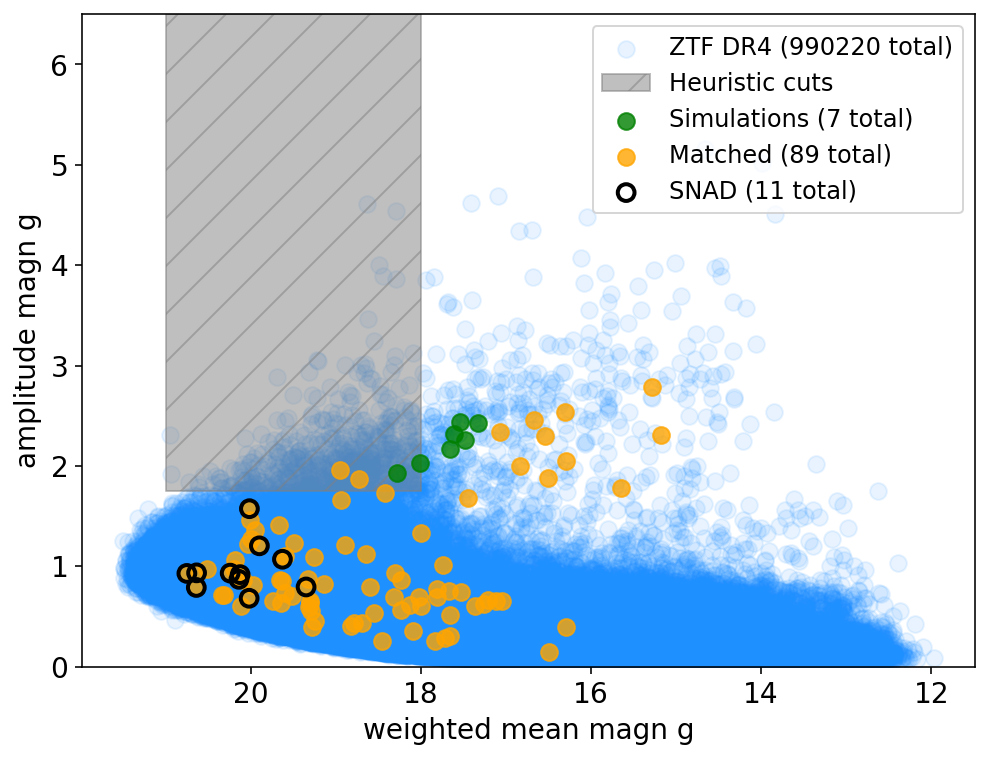

In [23]:
fig, ax = plt.subplots(figsize=(8,6))

y_feat = 'amplitude_magn_g'
x_feat = 'weighted_mean_magn_g'
size=70 

if x_feat == 'weighted_mean_magn_g':
    ax.invert_xaxis()
    
ax.scatter(remainder_dr4_df[x_feat], remainder_dr4_df[y_feat], 
           color='dodgerblue', alpha=0.1, s=size, label=f'ZTF DR4 ({len(dr4_df)} total)')

sx = np.array([21, 18, 19, 18])
sy1 = np.array([1.75, 1.75, 1.75, 1.75])
sy2 = np.array([6.5, 6.5, 1.75, 1.75])
plt.fill_between(sx, sy1, sy2, where=(sy1 < sy2), color='grey', alpha=0.5, hatch='/', label='Heuristic cuts')

ax.scatter(fakes_df[x_feat], fakes_df[y_feat], 
           color='g', alpha=0.8, s=size, label=f'Simulations ({len(fakes_df)} total)')
ax.scatter(unique_dr4_match_df[x_feat], unique_dr4_match_df[y_feat], 
           color='orange', alpha=0.8, s=size, label=f'Matched ({len(unique_dr4_match_df)} total)')
ax.scatter(snad_149_to_159_snids_df[x_feat], snad_149_to_159_snids_df[y_feat], 
           facecolors='none', edgecolors='k', linewidth=2, alpha=1, s=size, label=f'SNAD ({len(snad_149_to_159_snids_df)} total)')

plt.ylim(0,6.5)
ax.set_xlabel(x_feat.replace('_', ' '), fontsize=14)
ax.set_ylabel(y_feat.replace('_', ' '), fontsize=14)    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', ncol=1, fancybox=True, shadow=False, fontsize=12)

plt.savefig(f'./figures/scatterplot_{x_feat}_vs_{y_feat}.png', dpi=300, bbox_inches='tight')

In [24]:
fakes_df.columns.to_list()

['amplitude_magn_g',
 'anderson_darling_normal_magn_g',
 'beyond_1_std_magn_g',
 'beyond_2_std_magn_g',
 'cusum_magn_g',
 'inter_percentile_range_2_magn_g',
 'inter_percentile_range_10_magn_g',
 'inter_percentile_range_25_magn_g',
 'kurtosis_magn_g',
 'linear_fit_slope_magn_g',
 'linear_fit_slope_sigma_magn_g',
 'linear_trend_magn_g',
 'linear_trend_sigma_magn_g',
 'magnitude_percentage_ratio_40_5_magn_g',
 'magnitude_percentage_ratio_20_5_magn_g',
 'mean_magn_g',
 'median_absolute_deviation_magn_g',
 'median_buffer_range_percentage_10_magn_g',
 'median_buffer_range_percentage_20_magn_g',
 'percent_amplitude_magn_g',
 'percent_difference_magnitude_percentile_5_magn_g',
 'percent_difference_magnitude_percentile_10_magn_g',
 'period_s_to_n_0_magn_g',
 'period_s_to_n_1_magn_g',
 'period_s_to_n_2_magn_g',
 'period_s_to_n_3_magn_g',
 'period_s_to_n_4_magn_g',
 'periodogram_beyond_2_std_magn_g',
 'periodogram_beyond_3_std_magn_g',
 'periodogram_standard_deviation_magn_g',
 'skew_magn_g',
 's